# Shadow removal with luminance clustering and color clustering
On this algorithm the approach was to first detect the lit, penumbra and umbra regions by clustering the dataset using luminance as attribute, detect subregions,assuming there are 3 of them (road and woods, leafs, sky), of each previous clusters by clustering each of them using the color channels as main attributes and then equalizing these subregions according to its lit correspondent region.

In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

## Enhancing image with adaptive denoising
Considering in this work the specific scenarios of eucalyptus forests are really noisy, an adaptive denoise filter was implemented, so the noisy regions became smoother without loosing the borders.

In [2]:
# Adaptive Denoising
def adaptive_denoising(g, k, gamma, denoise_mode, iterations=1):
    # calculate the center of kernel
    a = k//2

    # create a zero matrix to fill with denoising result
    r = np.zeros(g.shape)
    
    for i in range(iterations):
        # declaration of image dispersion measure, local dispersion measure and centrality measure
        gdisp = 0.0
        ldisp = 0.0
        centr = 0.0

        # compute the estimation of the image global dispersion in a determined subregion of the image accordig to the assignment description
        subregion = g[0:(g.shape[0]//6), 0:(g.shape[1]//6)]
        if(denoise_mode == "average"):
            gdisp = np.std(subregion)
        if(denoise_mode == "robust"):
            q1, c, q2 = np.percentile(subregion, [25, 50, 75])
            gdisp = q2 - q1

        # "If the dispersion measure computed for some image is 0, then manually set it to 1"
        if(gdisp == 0):
            gdisp = 1

        # loop to run all over the image and denoise it
        for x in range(g.shape[0]):
            for y in range(g.shape[1]):
                # if running at the border of the image, when the filter kernel exceeds the limits of the image
                # then the resulting value is the copy of original image's pixel.
                if(x<a or x>(g.shape[0]-a) or y<a or y>(g.shape[1]-a)):
                    r[x,y] = g[x,y]

                # else compute the filter
                else:
                    # Sx is the image region, kernel size, to be filtered
                    Sx = g[x-a:(x+a+1), y-a:(y+a+1)]

                    # compute the local dispersion and centrality measure, according to denoise mode (average/robust)
                    if(denoise_mode == "average"):
                        # if denoise mode is average, dispersion is standard deviation and the centrality is the mean of region Sx
                        ldisp = np.std(Sx)
                        centr = np.mean(Sx)
                    elif(denoise_mode == "robust"):
                        # if denoise mode is robust, dispersion is interquartile range and the centrality is the median of region Sx
                        q1, centr, q2 = np.percentile(Sx, [25, 50, 75])
                        ldisp = q2 - q1

                    # "If during the denoising step, any local dispersion measure is 0, then set it so that local dispersion = global dispersion"
                    if(ldisp == 0):
                        ldisp = gdisp

                    # formula of adaptive denoising
                    r[x,y] = int(g[x,y] - gamma*(gdisp/ldisp)*(g[x,y]-centr))
    
    return r

In [3]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

In [4]:
""" Reading image """
img = imageio.imread("../images/shadow5.jpg")
for i in range(3):
    img[:,:,i] = adaptive_denoising(img[:,:,i],3,0.005,"robust")

## Luminance clustering
To detect the three luminance regions (lit, penumbra and umbra) on scenario the luminance clustering is computed, using as attribute the luminance, which is calculated with the form:

*luminance = 0.299 * R + 0.587 * G + 0.114 * B*

After computing the three clusters, an adaptive filter is applied to remove the noise.

In [5]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [6]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

In [7]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                try:
                    if(np.sum(dataset[x,y][:3]) == 0):
                        label_img[x,y] = 0
                    else:
                        # collect an example object from dataset to be labeled
                        example = dataset[x,y]

                        # according to similarity, select the cluster in which the example belongs
                        cluster = closest_cluster(centroids, example)
                        # set the label_img pixel value to cluster's number
                        label_img[x,y] = cluster
                except:
                    if(np.sum(dataset[x,y]) == 0):
                        label_img[x,y] = 0
                    else:
                        # collect an example object from dataset to be labeled
                        example = dataset[x,y]

                        # according to similarity, select the cluster in which the example belongs
                        cluster = closest_cluster(centroids, example)
                        # set the label_img pixel value to cluster's number
                        label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
        
    return label_img

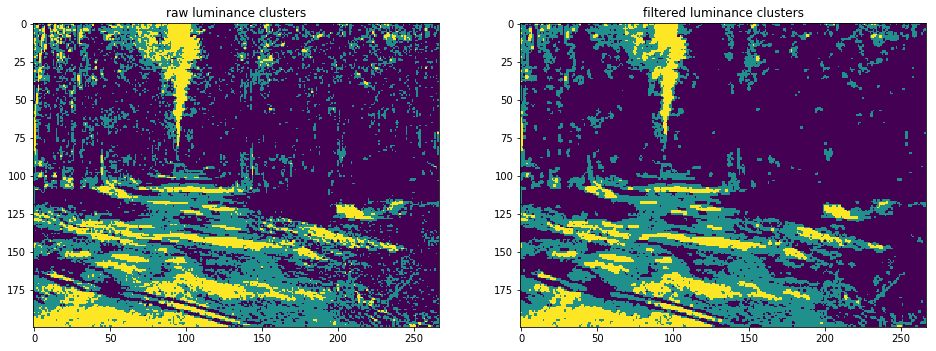

In [8]:
luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

# luminance_centroids = np.array([[np.min(luminance_dataset)], [np.max(luminance_dataset)]])
luminance_centroids = np.array([[np.min(luminance_dataset)], 
                                [np.max(luminance_dataset)*2/3], 
                                [np.max(luminance_dataset)]])

# lus = kmeans_routine(luminance_dataset, luminance_centroids, 2, 1)
lus = kmeans_routine(luminance_dataset, luminance_centroids, luminance_centroids.shape[0], 5)
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(lus); plt.title("raw luminance clusters")

lus = adaptive_denoising(lus, 3, 0.005, "robust",1)

plt.subplot(122); plt.imshow(lus); plt.title("filtered luminance clusters")
plt.savefig("filtered_luminance_clusters")

## Subregion clustering based on colors
Following the similar logistic of previews try algorithm (3rdTry.ipynb), and defining the method empirically, for lit regions the subregions clustering showed better results using as attributes the color channels (R,G,B) and the pixel position. 

On the other hand, for penumbra and umbra regions the subregions clustering showed better results using as attributes only the color channels (R,G,B).

In [9]:
lit_mask = np.zeros((img.shape[0], img.shape[1]))
penumbra_mask = np.zeros((img.shape[0], img.shape[1]))
umbra_mask = np.zeros((img.shape[0], img.shape[1]))

lit_mask[np.where(lus==3)] = 1
penumbra_mask[np.where(lus==2)] = 1
umbra_mask[np.where(lus==1)] = 1

lit_img = np.zeros(img.shape, dtype=np.uint8)
penumbra_img = np.zeros(img.shape, dtype=np.uint8)
umbra_img = np.zeros(img.shape, dtype=np.uint8)
for i in range(3):
    lit_img[:,:,i] = np.multiply(lit_mask,img[:,:,i])
    penumbra_img[:,:,i] = np.multiply(penumbra_mask,img[:,:,i])
    umbra_img[:,:,i] = np.multiply(umbra_mask,img[:,:,i])

In [10]:
lit_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

indx = np.arange(0, lit_img.shape[1])
indy = np.arange(0, lit_img.shape[0])
x,y = np.meshgrid(indx, indy)
lit_dataset = np.dstack((lit_img, x, y))

lit_centroids=np.array([[255,0,0,img.shape[1]//2,img.shape[0]-1],
                         [0,255,0,img.shape[1]//2,0],
                        [0,255,0,img.shape[1]//2,-1],
                         [0,0,255,img.shape[1]//2,0]])

lit_clusters_mask = kmeans_routine(lit_dataset, lit_centroids, 4, 1)

In [11]:
penumbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

penumbra_dataset = penumbra_img

penumbra_centroids=np.array([[255,0,0],
                         [0,255,0],
                         [0,0,255]])

penumbra_clusters_mask = kmeans_routine(penumbra_dataset, penumbra_centroids, 3, 1)

In [12]:
umbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

umbra_dataset = umbra_img

umbra_centroids=np.array([[255,0,0],
                         [0,255,0],
                         [0,0,255]])

umbra_clusters_mask = kmeans_routine(umbra_dataset, umbra_centroids, 3, 1)

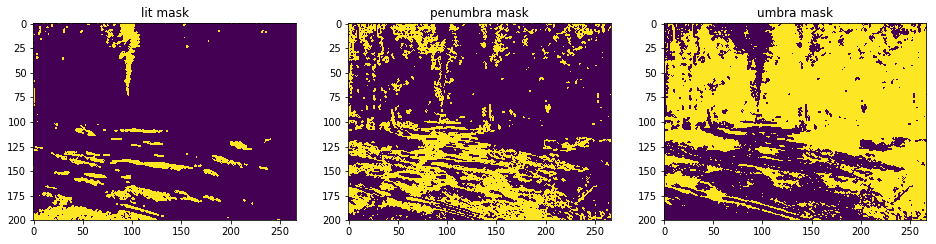

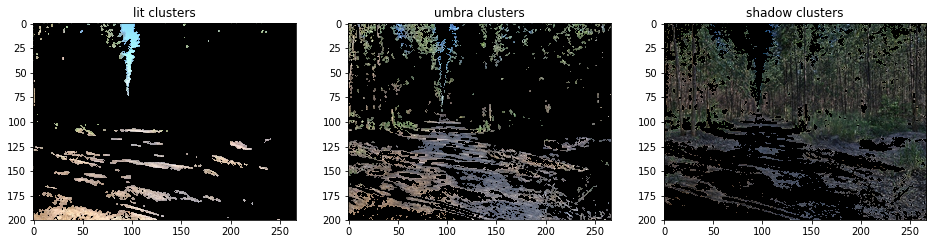

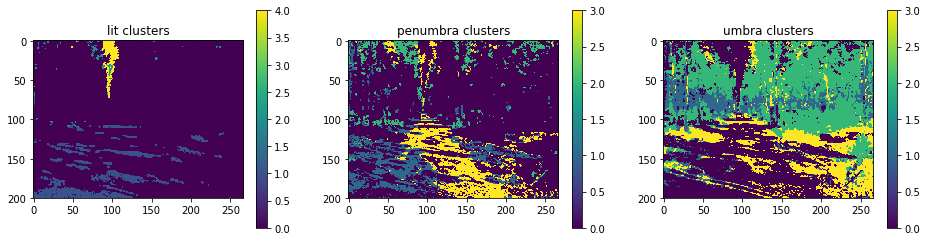

In [13]:
plt.figure(figsize=(16,4))
plt.subplot(131);plt.imshow(lit_mask);plt.title("lit mask")
plt.subplot(132);plt.imshow(penumbra_mask);plt.title("penumbra mask")
plt.subplot(133);plt.imshow(umbra_mask);plt.title("umbra mask")

plt.figure(figsize=(16,4))
plt.subplot(131);plt.imshow(lit_img);plt.title("lit clusters")
plt.subplot(132);plt.imshow(penumbra_img);plt.title("umbra clusters")
plt.subplot(133);plt.imshow(umbra_img);plt.title("shadow clusters")
plt.savefig("lit_penumbra_umbra")

plt.figure(figsize=(16,4))
plt.subplot(131);plt.imshow(lit_clusters_mask);plt.title("lit clusters");plt.colorbar()
plt.subplot(132);plt.imshow(penumbra_clusters_mask);plt.title("penumbra clusters");plt.colorbar()
plt.subplot(133);plt.imshow(umbra_clusters_mask);plt.title("umbra clusters");plt.colorbar()
plt.savefig("4thTry_subregions_clustering")

## Removing shadow regions
Analysing the previews step's result, visually can be seen that for lit regions, the cluster labeled as 1 is mostly refered to the road, for penumbra regions, the clusters 1 and 3 are mostly refered to the road on scene, while on umbra just the cluster labeled 3. Where label 1 centroid is max value for red channel, label 2 centroid is set max value for green channel, and label 3 centroid is set max value for blue channel.

So, according to this analysis, it was done the following:
- On penumbra regions: clusters 1 and 3 considered as road, cluster 2 as green leafs from forest.
- On umbra regions: cluster 1 as road, cluster 2 as green leafs from forest, cluster 3 as woods from forest.
- On lit regions: cluster 1 as road, clusters 2 and 3 as green leafs from forest, cluster 4 as sky.

Based on that the color histogram equalizations were performed.

In [14]:
def remove_shadow(img, mask, ref_mask):
    mask_coordinates = np.where(mask==1)
    ref_coordinates = np.where(ref_mask==1)

    # loop for each color layer
    for c in range(3):
        refmean = np.average(img[np.where(ref_mask==1)][:,c])
        
        refmin = np.min(img[ref_coordinates][:,c])
        refmax = np.max(img[ref_coordinates][:,c])
        
        maskmean = np.average(img[np.where(mask==1)][:,c])
        maskmin = np.min(img[mask_coordinates][:,c])
        maskmax = np.max(img[mask_coordinates][:,c])
        
        diff = refmean - maskmean

        for i in range(mask_coordinates[0].shape[0]):
            x,y,z=mask_coordinates[0][i],mask_coordinates[1][i],c
            img[x,y,z]=((float(img[x,y,z])-maskmin)*(refmax - refmin)/(maskmax - maskmin)) + refmin
#             img[x,y,z]+= (diff + refstd)
        
    return img

In [18]:
img_copy = np.copy(img)

penumbra_blue_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_blue_mask[np.where(penumbra_clusters_mask == 3)] = 1

penumbra_red_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_red_mask[np.where(penumbra_clusters_mask == 1)] = 1

umbra_blue_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_blue_mask[np.where(umbra_clusters_mask == 3)] = 1

umbra_red_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_red_mask[np.where(umbra_clusters_mask == 1)] = 1

lit_red_mask = np.zeros(lit_clusters_mask.shape, dtype=np.uint8)
lit_red_mask[np.where(lit_clusters_mask==1)] = 1

# equalize blue penumbra region with red penumbra region
img_copy = remove_shadow(img_copy, penumbra_blue_mask, penumbra_red_mask)

# equalize blue umbra region with red umbra region
img_copy = remove_shadow(img_copy, umbra_blue_mask, penumbra_red_mask)

# remove umbra on road region
umbra_road_mask = umbra_blue_mask

img_copy = remove_shadow(img_copy, umbra_road_mask, lit_red_mask)

# remove umbra on woods
umbra_woods_mask = umbra_red_mask
img_copy = remove_shadow(img_copy, umbra_woods_mask, penumbra_blue_mask)

# remove penumbra on road region
penumbra_road_mask = penumbra_blue_mask + penumbra_red_mask

img_copy = remove_shadow(img_copy, penumbra_road_mask, lit_red_mask)

# equalize green penumbra region
penumbra_green_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_green_mask[np.where(penumbra_clusters_mask == 2)] = 1

umbra_green_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_green_mask[np.where(umbra_clusters_mask == 2)] = 1

lit_green_mask = np.zeros(lit_clusters_mask.shape, dtype=np.uint8)
lit_green_mask[np.where(lit_clusters_mask == 2)] = 1

img_copy = remove_shadow(img_copy, penumbra_green_mask, lit_green_mask)
img_copy = remove_shadow(img_copy, umbra_green_mask, penumbra_green_mask)

## Results and discution
This approach showed much better results in comparison with all others in terms of approximate the color distribution on shadow (penumbra and umbra) regions from the lit regions.

To be able of analysing the level of values on each channel before and after running the program, it was plotted the graph containing a vertical and horizontal section of the images.

So, taking on of the last rows of the image, in which there are almost half of pixels on lit regions and the other half on shadowed regions, it is possible to see the result. On original image, the shadowed pixels have lower values and indeed the blue channel has higher values upon other two color channels; on the other hand, after running the program, the levels of values on shadowed regions are more likely the lit regions.

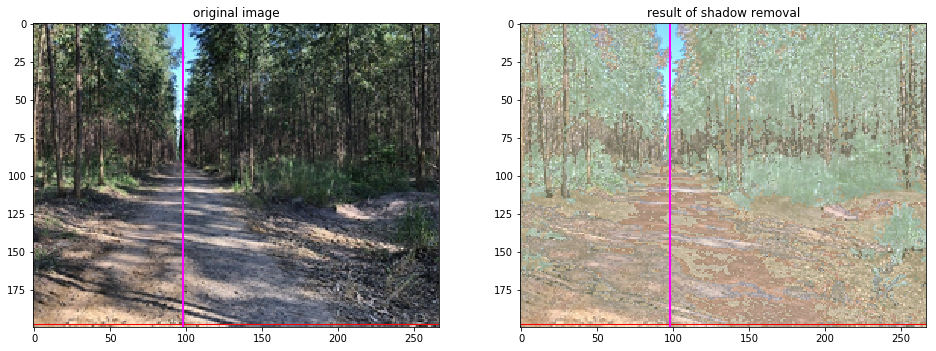

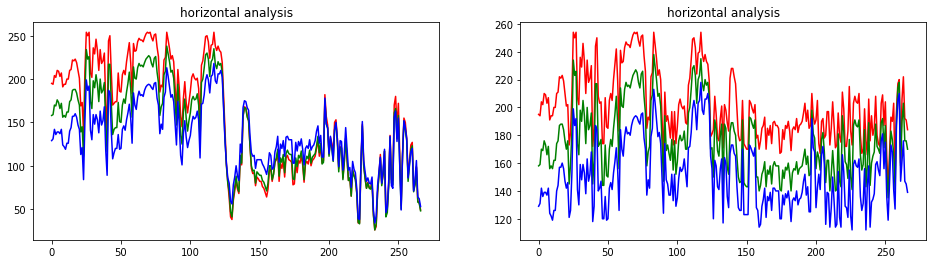

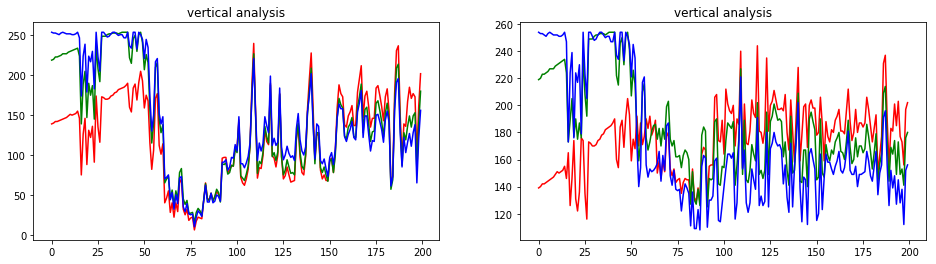

In [19]:
vline = 98
hline = -2
original = np.copy(img)
result = np.copy(img_copy)
original[hline,:] = [255,0,0]
result[hline,:] = [255,0,0]
original[:,vline] = [255,0,255]
result[:,vline] = [255,0,255]

plt.figure(figsize=(16,8))
plt.subplot(121);plt.imshow(original);plt.title("original image")
plt.subplot(122);plt.imshow(result); plt.title("result of shadow removal")
plt.savefig("lined_results")

plt.figure(figsize=(16,4))
plt.subplot(121);plt.title("horizontal analysis")
plt.plot(img[hline,:,0],'r');plt.plot(img[hline,:,1],'g');plt.plot(img[hline,:,2],'b')
plt.subplot(122); plt.title("horizontal analysis")
plt.plot(img_copy[hline,:,0],'r');plt.plot(img_copy[hline,:,1],'g');plt.plot(img_copy[hline,:,2],'b')
plt.savefig("horiontal_analysis")

plt.figure(figsize=(16,4))
plt.subplot(121);plt.title("vertical analysis")
plt.plot(img[:,vline,0],'r');plt.plot(img[:,vline,1],'g');plt.plot(img[:,vline,2],'b')
plt.subplot(122); plt.title("vertical analysis")
plt.plot(img_copy[:,vline,0],'r');plt.plot(img_copy[:,vline,1],'g');plt.plot(img_copy[:,vline,2],'b')
plt.savefig("vertical_analysis")

## Conclusion
The idea of removing shadows from a scenario of eucalyptus forest is very complex since there are many small and thin details (dry leafs on the ground, the woods) that are not necessarily noise, depending of what is the purpose of the image caption.

So, in the end, with this approach it was not possible to properly remove the shadow and keeping quality of image, instead a lot of information was lost in the end, as can be seen.

But, if consider this a method to remove the noise caused by the shadow regions when the goal is to segment road from other things (obstacles, fore example), it seems to fulfill the requisite. 

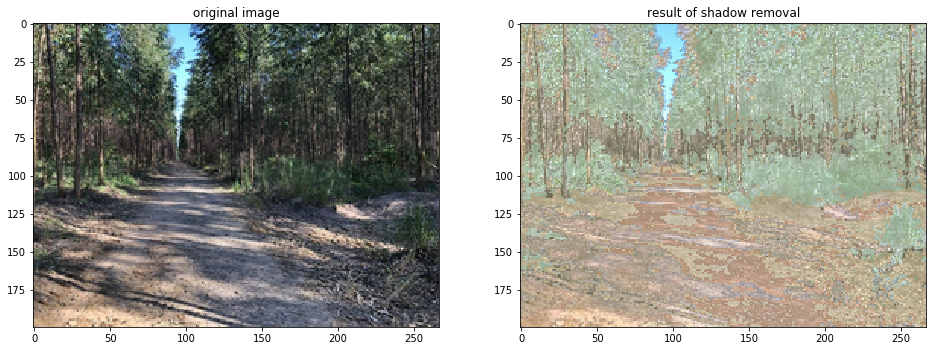

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(121);plt.imshow(img);plt.title("original image")
plt.subplot(122);plt.imshow(img_copy); plt.title("result of shadow removal")
plt.savefig("resulting_shadow_removal")